# Likelihood and Nested Sampling 

Accretion disk model with the addition of the $q$ parameter.

### Import functions and stuff from pydd

In [2]:
import numpy as np
import scipy
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.interpolate import interp1d

from pydd.analysis import get_match_pads
from pydd.binary import get_m_1, get_f_isco, get_m_2

import pickle
from typing import Tuple

import dynesty
from dynesty import plotting as dyplot

from tqdm.auto import trange
import corner
from scipy.interpolate import griddata
from scipy.stats import scoreatpercentile

/Users/nicolegrillo/miniconda3/lib/python3.10/site-packages/pydd/binary.py:521: RuntimeWarning: invalid value encountered in log10
  vals_neg = np.log10(1 - hypgeom_scipy(-b_mg[::-1, :], z_mg))


In [3]:
import environments_handy_functions

# Reload libraries (in case you change something)
import importlib
importlib.reload(environments_handy_functions)

from environments_handy_functions import (
    df_dt,  
    find_grid, 
    time_to_coal_cumul,  
    phase_f_cumul, 
    f_1yr, 
    h_0, 
    mycalculate_SNR, 
    amplitude, 
    Psi,
    myVacuumBinary, myAccretionDisk, myDarkMatter, myCombination)

In [4]:
G = 6.67408e-11  # m^3 s^-2 kg^-1
C = 299792458.0  # m/s
MSUN = 1.98855e30  # kg
PC = 3.08567758149137e16  # m
YR = 365.25 * 24 * 3600  # s

In [5]:
plt.rcParams['agg.path.chunksize'] = 1000  # Set a larger value for chunksize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.sans-serif": ["TimesNewRoman"]})
plt.rcParams["mathtext.fontset"] = "stix"
plt.rcParams["axes.labelsize"] = "14"

## True values for plotting

In [6]:
m1 = 1e5 * MSUN # kg
m2 = 10 * MSUN # kg
r_s = 2 * G * m1/ C**2 # Schwartzschild radius of m1
r0 = 3 * r_s
Mach = 100
sigma0 = 1.5e10 / Mach**2
alpha = -1/2
chirp_mass=(m1 * m2)**(3/5) / (m1 + m2)**(1/5)
q = m2/m1

In [7]:
# from priors to true vals in translated system

true_value = np.array([chirp_mass, sigma0, alpha, q])

log_sigma0_true= np.log10(true_value[1])
m_true = 0
alpha_true = 0
logq_true = np.log10(true_value[3])

## Nested Sampling results (noiseless)

In [12]:
with open('sampling-results/sampling_results_accwithq.pkl', 'rb') as f:
    data_out = pickle.load(f)

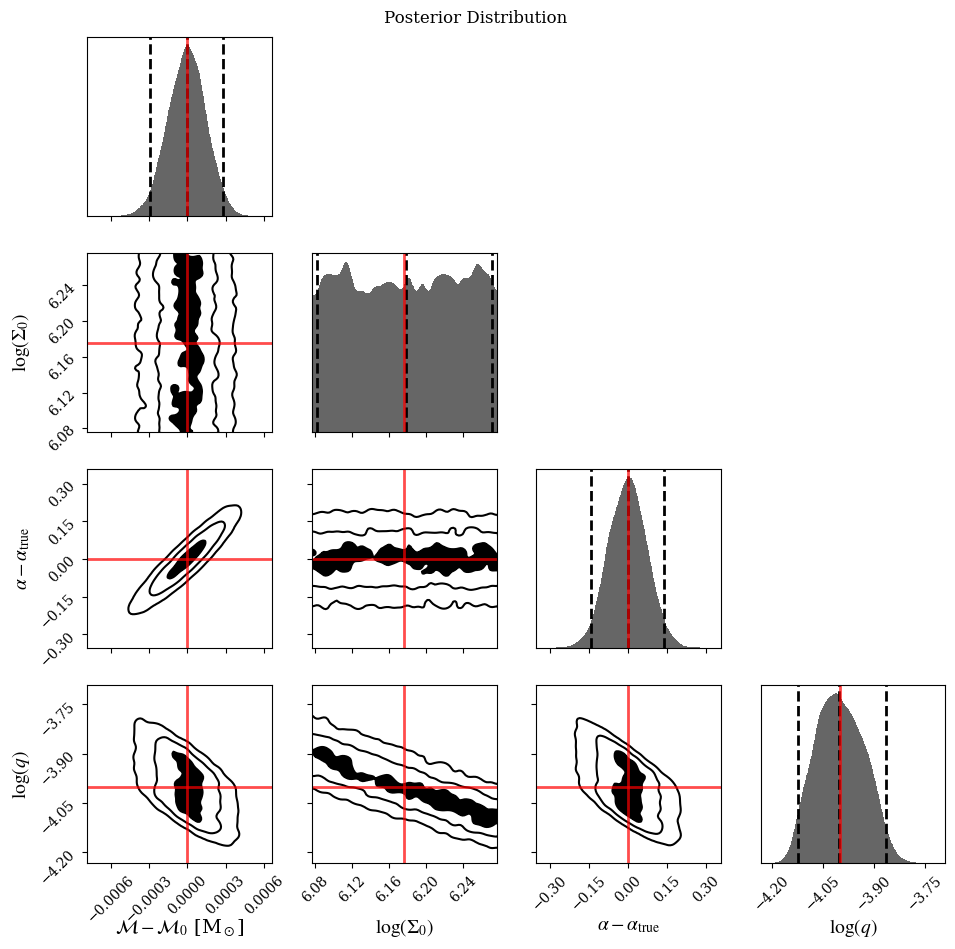

In [13]:
labels = [r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]", r"$\log(\Sigma_0)$", r'$\alpha - \alpha_{\mathrm{true}}$', r"$\log(q)$"]
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    data_out, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[m_true, log_sigma0_true, alpha_true, logq_true] 
    #verbose=True
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()
plt.show()

In [17]:
class CustomResults:
    def __init__(self, samples, log_weights):
        self.samples = samples
        self.logwt = log_weights

    def __getitem__(self, key):
        if key == 'samples':
            return self.samples
        elif key == 'logwt':
            return self.logwt
        else:
            raise KeyError(f"Invalid key '{key}'")

    def importance_weights(self):
        # Calculate importance weights for each set of samples based on log weights
        return np.exp(self.logwt - np.max(self.logwt))

    def __len__(self):
        # Return the number of sets of samples (number of rows)
        return self.samples.shape[0]

In [21]:
chirp_mass_posterior = data_out.samples[:, 0]
log_sigma0_posterior = data_out.samples[:, 1]
alpha_posterior = data_out.samples[:, 2]
log_q_posterior = data_out.samples[:, 3]

chirp_mass_posterior_transformed = (chirp_mass_posterior * MSUN + true_value[0]) / MSUN # in units of solar masses
sigma0_posterior_transformed = 10**(log_sigma0_posterior)
alpha_posterior_transformed = (alpha_posterior + true_value[2]) 
q_posterior_transformed = 10**(log_q_posterior)

transformed_samples = np.vstack((chirp_mass_posterior_transformed, sigma0_posterior_transformed, alpha_posterior_transformed, q_posterior_transformed)).T

# Calculate log weights from results_1d 
log_weights = data_out.logwt

# Instantiate custom results object
custom_results = CustomResults(transformed_samples, log_weights)

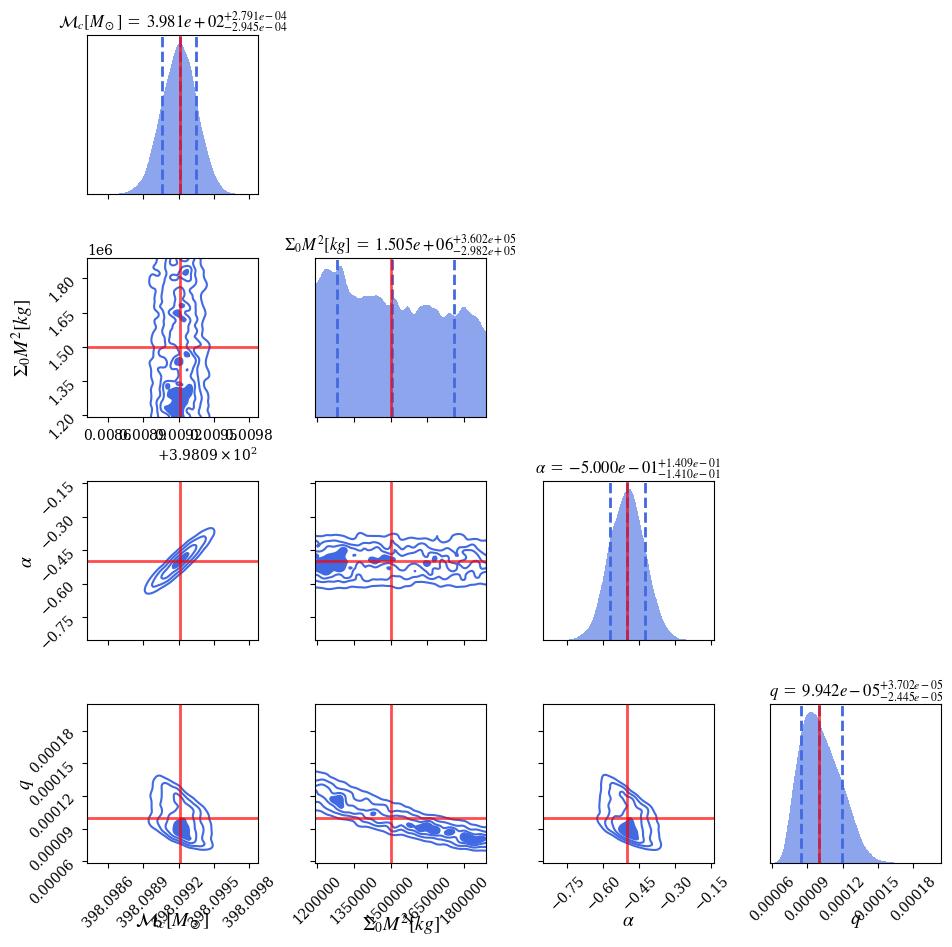

In [22]:
from matplotlib.ticker import ScalarFormatter

labels = [r"$\mathcal{M}_c [M_\odot]$", r"$\Sigma_0 M^2 [kg]$", r"$\alpha$", '$q$']

# Plot using dyplot.cornerplot with custom results structure
fig, axes = dyplot.cornerplot(
    custom_results,
    labels=labels,
    show_titles=True,
    title_fmt=".3e",
    title_kwargs={"fontsize": 12},
    quantiles=[0.16, 0.5, 0.84],
    truths=[true_value[0]/MSUN, true_value[1], true_value[2], true_value[3]],
    color='royalblue', 
    truth_color='red', 
)

# Customize the x-axis tick labels to scientific notation
axes[1, 0].xaxis.set_major_formatter(ScalarFormatter(useMathText=True))

plt.tight_layout()
plt.show()

---

# Including the noise 

## Nested sampling 

In [9]:
with open('sampling-results/sampling_results_accwithqN.pkl', 'rb') as f:
    data_out1 = pickle.load(f)

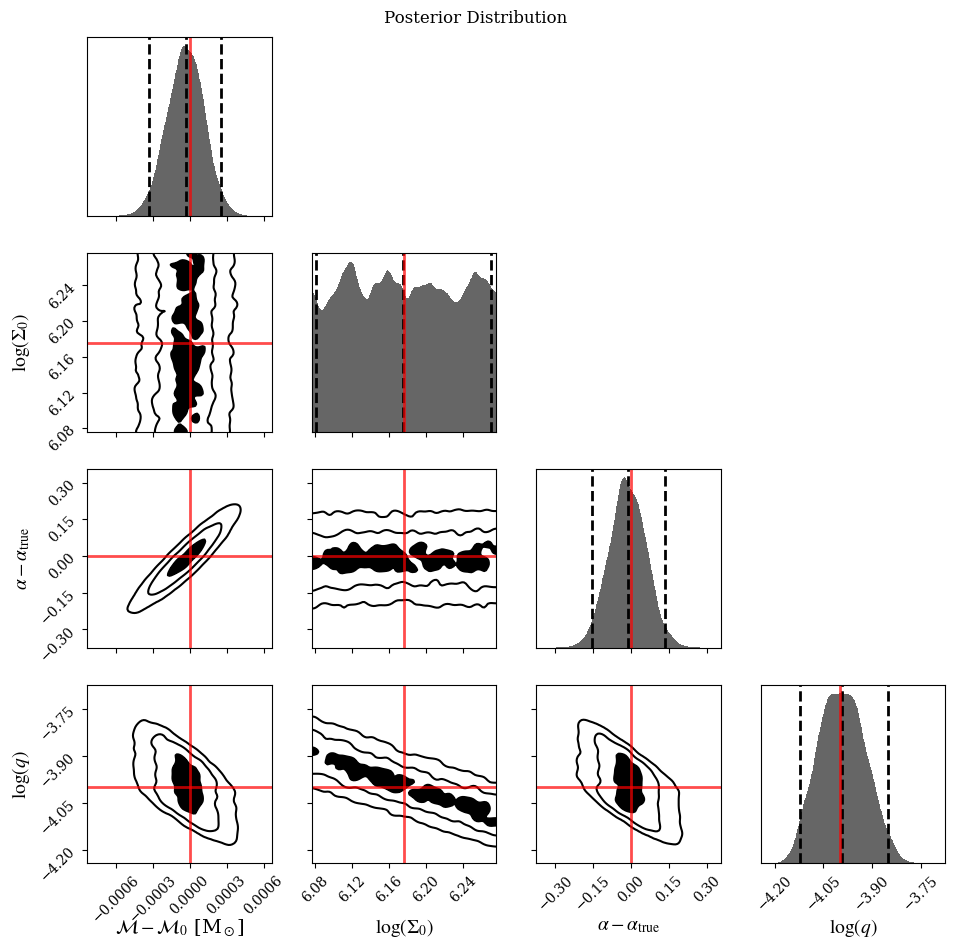

In [11]:
labels = [r"$\mathcal{M} - \mathcal{M}_0$ [M$_\odot$]", r"$\log(\Sigma_0)$", r'$\alpha - \alpha_{\mathrm{true}}$', r"$\log(q)$"]
quantiles_2d = [1 - np.exp(-(x ** 2) / 2) for x in [1, 2, 3]]

fig, axes = dyplot.cornerplot(
    data_out1, 
    labels=labels, 
    quantiles_2d=quantiles_2d, 
    truths=[m_true, log_sigma0_true, alpha_true, logq_true] 
    #verbose=True
)

fig.suptitle("Posterior Distribution")
plt.tight_layout()
plt.savefig('figures/ACCRETION_noisy.png')
plt.show()

# On the degeneracy of the $q \Sigma_0$ pair

The pair of $q \Sigma_0$ parameters is half degenerate, meaning that they always appear together in the expressions to calculate the waveform which goes into the likelihood function. 

This means that in calculating the posterior we always have their contribution as a whole, making it difficult to distinguish whether the disk is compatible with larger $q$s and smaller $\Sigma_0$ or vice versa. 

The interested quantities where the term appears are: 

- Amplitude (in the amplitude function); 
- $\Psi$ functions; 
- $\ddot{\Phi}$, through $\frac{df}{dt}$. 

These are also the terms I checked to verify the above statement "by hand".